In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0623 - acc: 0.3663
Epoch 00001: val_loss improved from inf to 1.68792, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_6_conv_checkpoint/001-1.6879.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.0624 - acc: 0.3663 - val_loss: 1.6879 - val_acc: 0.4517
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3169 - acc: 0.5971
Epoch 00002: val_loss improved from 1.68792 to 1.15169, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_6_conv_checkpoint/002-1.1517.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.3169 - acc: 0.5971 - val_loss: 1.1517 - val_acc: 0.6408
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0799 - acc: 0.6752
Epoch 00003: val_loss improved from 1.15169 to 0.98016, saving mode

36800/36805 [============================>.] - ETA: 0s - loss: 0.3313 - acc: 0.9052
Epoch 00026: val_loss did not improve from 0.57830
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3313 - acc: 0.9051 - val_loss: 0.7466 - val_acc: 0.7913
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3179 - acc: 0.9085
Epoch 00027: val_loss did not improve from 0.57830
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3181 - acc: 0.9084 - val_loss: 0.6237 - val_acc: 0.8323
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3102 - acc: 0.9131
Epoch 00028: val_loss did not improve from 0.57830
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3102 - acc: 0.9131 - val_loss: 0.6623 - val_acc: 0.8174
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2963 - acc: 0.9164
Epoch 00029: val_loss did not improve from 0.57830
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1224 - acc: 0.9687
Epoch 00056: val_loss did not improve from 0.54955
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1225 - acc: 0.9687 - val_loss: 0.5920 - val_acc: 0.8488
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9694
Epoch 00057: val_loss did not improve from 0.54955
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1204 - acc: 0.9693 - val_loss: 0.6993 - val_acc: 0.8302
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9690
Epoch 00058: val_loss did not improve from 0.54955
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1203 - acc: 0.9690 - val_loss: 0.5985 - val_acc: 0.8521
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9721
Epoch 00059: val_loss did not improve from 0.54955
36805/36805 [===========

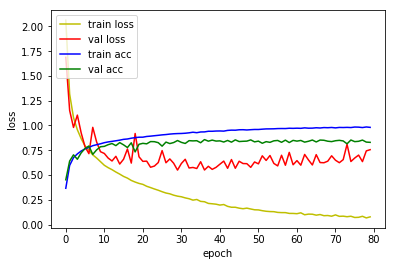

4815/4815 [==============================] - 4s 889us/sample - loss: 0.6642 - acc: 0.8085
Loss: 0.6641759217837642 Accuracy: 0.8085151

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3944 - acc: 0.2611
Epoch 00001: val_loss improved from inf to 1.98862, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_7_conv_checkpoint/001-1.9886.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.3944 - acc: 0.2611 - val_loss: 1.9886 - val_acc: 0.3454
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5628 - acc: 0.5163
Epoch 00002: val_loss improved from 1.98862 to 1.36716, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_7_conv_checkpoint/002-1.3672.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5629 - acc: 0.5163 - val_loss: 1.3672 - val_acc: 0.5772
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2734 - acc: 0.9228
Epoch 00025: val_loss improved from 0.38070 to 0.36858, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_7_conv_checkpoint/025-0.3686.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2734 - acc: 0.9228 - val_loss: 0.3686 - val_acc: 0.8973
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2656 - acc: 0.9235
Epoch 00026: val_loss did not improve from 0.36858
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2656 - acc: 0.9235 - val_loss: 0.3732 - val_acc: 0.8908
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2581 - acc: 0.9260
Epoch 00027: val_loss improved from 0.36858 to 0.36145, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_7_conv_checkpoint/027-0.3615.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2581 - acc: 0.9260 - val_loss: 0.3

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1156 - acc: 0.9685
Epoch 00052: val_loss did not improve from 0.31156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1156 - acc: 0.9685 - val_loss: 0.3293 - val_acc: 0.9101
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1072 - acc: 0.9712
Epoch 00053: val_loss did not improve from 0.31156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1073 - acc: 0.9711 - val_loss: 0.3598 - val_acc: 0.9080
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9697
Epoch 00054: val_loss did not improve from 0.31156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1112 - acc: 0.9697 - val_loss: 0.3520 - val_acc: 0.9026
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1055 - acc: 0.9717
Epoch 00055: val_loss did not improve from 0.31156
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0678 - acc: 0.9815
Epoch 00082: val_loss did not improve from 0.31156
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0680 - acc: 0.9814 - val_loss: 0.3826 - val_acc: 0.9080
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9830
Epoch 00083: val_loss did not improve from 0.31156
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0640 - acc: 0.9830 - val_loss: 0.4254 - val_acc: 0.8966
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0570 - acc: 0.9848
Epoch 00084: val_loss did not improve from 0.31156
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0573 - acc: 0.9848 - val_loss: 0.3595 - val_acc: 0.9131
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9860
Epoch 00085: val_loss did not improve from 0.31156
36805/36805 [===========

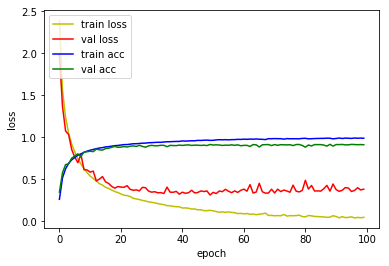

4815/4815 [==============================] - 4s 910us/sample - loss: 0.3951 - acc: 0.8854
Loss: 0.39509355115741956 Accuracy: 0.8853583

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3080 - acc: 0.2892
Epoch 00001: val_loss improved from inf to 1.92401, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_8_conv_checkpoint/001-1.9240.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 2.3080 - acc: 0.2892 - val_loss: 1.9240 - val_acc: 0.4067
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4858 - acc: 0.5458
Epoch 00002: val_loss improved from 1.92401 to 1.25807, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_8_conv_checkpoint/002-1.2581.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4859 - acc: 0.5458 - val_loss: 1.2581 - val_acc: 0.6164
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9430
Epoch 00024: val_loss improved from 0.24335 to 0.24012, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_8_conv_checkpoint/024-0.2401.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1945 - acc: 0.9430 - val_loss: 0.2401 - val_acc: 0.9283
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1845 - acc: 0.9465
Epoch 00025: val_loss did not improve from 0.24012
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1847 - acc: 0.9465 - val_loss: 0.2802 - val_acc: 0.9129
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1806 - acc: 0.9469
Epoch 00026: val_loss did not improve from 0.24012
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1808 - acc: 0.9469 - val_loss: 0.2908 - val_acc: 0.9117
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1728 - acc

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9827
Epoch 00052: val_loss did not improve from 0.20856
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0654 - acc: 0.9826 - val_loss: 0.2363 - val_acc: 0.9327
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0622 - acc: 0.9835
Epoch 00053: val_loss did not improve from 0.20856
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0623 - acc: 0.9835 - val_loss: 0.2581 - val_acc: 0.9338
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9816
Epoch 00054: val_loss did not improve from 0.20856
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0683 - acc: 0.9816 - val_loss: 0.2483 - val_acc: 0.9322
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9850
Epoch 00055: val_loss did not improve from 0.20856
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9862
Epoch 00082: val_loss did not improve from 0.20856
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0467 - acc: 0.9862 - val_loss: 0.2484 - val_acc: 0.9413
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9941
Epoch 00083: val_loss did not improve from 0.20856
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0269 - acc: 0.9941 - val_loss: 0.2410 - val_acc: 0.9436
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9943
Epoch 00084: val_loss did not improve from 0.20856
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0259 - acc: 0.9943 - val_loss: 0.2544 - val_acc: 0.9371
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9940
Epoch 00085: val_loss did not improve from 0.20856
36805/36805 [===========

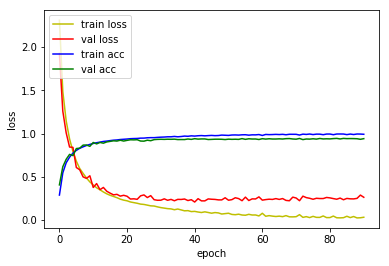

4815/4815 [==============================] - 4s 914us/sample - loss: 0.2823 - acc: 0.9205
Loss: 0.28225236821026073 Accuracy: 0.9204569

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4010 - acc: 0.2596
Epoch 00001: val_loss improved from inf to 1.97689, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_9_conv_checkpoint/001-1.9769.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 2.4010 - acc: 0.2596 - val_loss: 1.9769 - val_acc: 0.3995
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5321 - acc: 0.5379
Epoch 00002: val_loss improved from 1.97689 to 1.26088, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_9_conv_checkpoint/002-1.2609.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.5322 - acc: 0.5378 - val_loss: 1.2609 - val_acc: 0.6278
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.1875 - acc: 0.9471
Epoch 00024: val_loss improved from 0.24341 to 0.23690, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_BN_9_conv_checkpoint/024-0.2369.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1875 - acc: 0.9471 - val_loss: 0.2369 - val_acc: 0.9294
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1779 - acc: 0.9509
Epoch 00025: val_loss did not improve from 0.23690
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1779 - acc: 0.9509 - val_loss: 0.2713 - val_acc: 0.9203
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9499
Epoch 00026: val_loss did not improve from 0.23690
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1733 - acc: 0.9499 - val_loss: 0.2417 - val_acc: 0.9266
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1667 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9836
Epoch 00052: val_loss did not improve from 0.22640
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0634 - acc: 0.9836 - val_loss: 0.2459 - val_acc: 0.9322
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9822
Epoch 00053: val_loss did not improve from 0.22640
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0649 - acc: 0.9821 - val_loss: 0.2760 - val_acc: 0.9252
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9813
Epoch 00054: val_loss did not improve from 0.22640
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0693 - acc: 0.9813 - val_loss: 0.2517 - val_acc: 0.9350
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9855
Epoch 00055: val_loss did not improve from 0.22640
36805/36805 [========================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9902
Epoch 00082: val_loss did not improve from 0.22640
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0344 - acc: 0.9901 - val_loss: 0.2750 - val_acc: 0.9338

1D_CNN_custom_2_ch_64_BN_9_conv Model


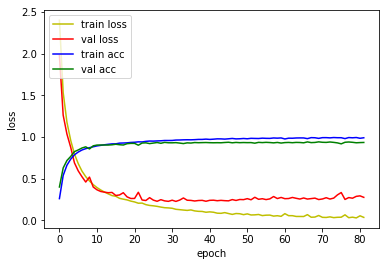

4815/4815 [==============================] - 5s 965us/sample - loss: 0.3099 - acc: 0.9074
Loss: 0.30990468353992434 Accuracy: 0.9073728



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_ch_64_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_ch_64_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_64_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5

4815/4815 [==============================] - 5s 976us/sample - loss: 0.3951 - acc: 0.8854
Loss: 0.39509355115741956 Accuracy: 0.8853583

1D_CNN_custom_2_ch_64_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_59 (Activation)   (Non

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3099 - acc: 0.9074
Loss: 0.30990468353992434 Accuracy: 0.9073728


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_64_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4460 - acc: 0.8864
Loss: 0.44596569009535286 Accuracy: 0.8863967

1D_CNN_custom_2_ch_64_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_59 (Activation)   (None,

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3694 - acc: 0.9092
Loss: 0.36937547893508077 Accuracy: 0.909242
